In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
from pennylane import numpy as pnp
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time

In [2]:
INPUT_SEQUENCE_LENGTH = 168 
OUTPUT_SEQUENCE_LENGTH = 72 
N_LOCATIONS = 20

In [3]:
n_qubits = 2 
n_layers = 1 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev = qml.device("lightning.qubit", wires=n_qubits)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev = qml.device("lightning.qubit", wires=n_qubits)

In [5]:
@qml.qnode(dev, interface="torch")
def q_circuit(inputs, weights):
    """A quantum circuit that acts as a feature extractor."""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [7]:
class QLSTMModel(nn.Module):
    """
    Hybrid Quantum-Classical model for multi-step forecasting.
    A classical LSTM processes the sequence, and its output is fed
    into a quantum circuit for feature extraction, followed by a
    classical layer for multi-step prediction.
    """
    def __init__(self, n_features, n_lstm_units=4, n_qubits=2, n_layers=1, output_len=OUTPUT_SEQUENCE_LENGTH):
        super(QLSTMModel, self).__init__()
        
        # 1. Classical LSTM Layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=1,
            batch_first=True
        )
        
        # 2. Classical Layer to map LSTM output to Quantum input
        self.classical_to_quantum = nn.Linear(n_lstm_units, n_qubits)
        
        # 3. Quantum Layer
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(q_circuit, weight_shapes)
        
        # 4. Classical Layer to map quantum output to predictions
        self.quantum_to_output = nn.Linear(n_qubits, output_len)
        
    def forward(self, x):        
        # 1. Pass data through the classical LSTM
        lstm_out, _ = self.lstm(x)
        
        # 2. Extract features from the last timestep
        final_lstm_output = lstm_out[:, -1, :]
        
        # 3. Prepare the data for the quantum circuit
        quantum_input = self.classical_to_quantum(final_lstm_output)
        
        # 4. Pass the features through the quantum circuit
        quantum_features = self.q_layer(quantum_input)
        
        # 5. Map quantum features to output sequence
        output = self.quantum_to_output(quantum_features)
        
        # 6. Apply sigmoid activation to get probabilities
        return torch.sigmoid(output)

In [8]:
def load_and_prepare_data():
    """Load and prepare data with memory optimizations"""
    print("Loading data...")
    if not os.path.exists('air_quality_2024_preproccessed.parquet'):
        raise FileNotFoundError("The data file 'air_quality_2024_preproccessed.parquet' was not found.")
    df = pq.read_table('air_quality_2024_preproccessed.parquet').to_pandas()
    print(f"Dataset shape: {df.shape}")
    
    le_location = LabelEncoder()
    df['location_encoded'] = le_location.fit_transform(df['location'])
    df = df.sort_values(['location_encoded', 'month', 'day', 'hour'])
    
    feature_columns = [col for col in df.columns if col not in [
        'class', 'location', 'month', 'day', 'hour', 'location_encoded'
    ]]
    feature_columns.append('location_encoded')
    
    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")
    
    return df, feature_columns, le_location

In [9]:
def create_sequences_memory_efficient(df, feature_columns, 
                                    input_len=INPUT_SEQUENCE_LENGTH,
                                    output_len=OUTPUT_SEQUENCE_LENGTH,
                                    stride=24):
    """Create sequences for multi-step forecasting."""
    print(f"Creating sequences with input length={input_len}, output length={output_len}...")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_columns])
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)
    
    X_sequences, y_sequences, location_indices = [], [], []
    unique_locations = df['location_encoded'].unique()
    
    for i, loc in enumerate(unique_locations):
        loc_df = df[df['location_encoded'] == loc]
        loc_X = X_scaled.loc[loc_df.index]
        loc_y = loc_df['class'].values
        
        max_start_idx = len(loc_df) - input_len - output_len
        
        for j in range(0, max_start_idx, stride):
            X_seq = loc_X.iloc[j : j + input_len].values
            y_target = loc_y[j + input_len : j + input_len + output_len]
            
            X_sequences.append(X_seq)
            y_sequences.append(y_target)
            location_indices.append(loc)
        
        if (i+1) % 100 == 0:
            print(f"Processed location {i+1}/{len(unique_locations)}")
    
    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.float32)
    location_indices = np.array(location_indices)
    
    print(f"Total sequences: {X_sequences.shape[0]}")
    print(f"Input sequence shape: {X_sequences.shape}")
    print(f"Output sequence shape: {y_sequences.shape}")
    
    return X_sequences, y_sequences, location_indices, scaler

In [10]:
def train_model_pytorch(model, train_loader, val_loader, epochs=10, patience=3):
    """Trains the PyTorch model for multi-step forecasting."""
    print("Starting training with PyTorch...")
    model.to(device)
    
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    history = defaultdict(list)
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss, train_correct, train_samples = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
            preds = (outputs > 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            train_samples += y_batch.size(0) * y_batch.size(1)  
        
        train_loss /= train_samples
        train_acc = train_correct / train_samples
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        
        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item() * X_batch.size(0)
                preds = (outputs > 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_samples += y_batch.size(0) * y_batch.size(1)
        
        val_loss /= val_samples
        val_acc = val_correct / val_samples
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        scheduler.step(val_loss)
        
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
              f"Duration: {epoch_duration:.2f}s")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_qlstm_model_multistep.pth')
            patience_counter = 0
            print("  -> Validation loss improved. Saving model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  -> Early stopping triggered.")
                break
                
    model.load_state_dict(torch.load('best_qlstm_model_multistep.pth'))
    return model, history

In [11]:
def plot_example_predictions(model, X_test, y_test, num_examples=3):
    """Plot example predictions vs actual values"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        sample_indices = np.random.choice(len(X_test), num_examples, replace=False)
        
        plt.figure(figsize=(15, 5 * num_examples))
        
        for i, idx in enumerate(sample_indices):
            X_sample = torch.tensor(X_test[idx:idx+1]).to(device)
            y_true = y_test[idx]
            
            y_pred_prob = model(X_sample).cpu().numpy()[0]
            y_pred_binary = (y_pred_prob > 0.5).astype(int)
            
            plt.subplot(num_examples, 1, i+1)
            hours = np.arange(1, OUTPUT_SEQUENCE_LENGTH + 1)
            plt.plot(hours, y_true, 'bo-', label='Actual')
            plt.plot(hours, y_pred_binary, 'ro--', label='Predicted')
            plt.title(f'Example {i+1}: Air Quality Prediction (Next 72 Hours)')
            plt.xlabel('Hours Ahead')
            plt.ylabel('Air Quality Class')
            plt.yticks([0, 1], ['Good', 'Poor'])
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('quantum_example_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

In [12]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.


In [13]:
df, feature_columns, le_location = load_and_prepare_data()

print(f"Using a subset of data for demonstration (first {N_LOCATIONS} locations)...")
unique_locs_subset = df['location_encoded'].unique()[:N_LOCATIONS]
df_subset = df[df['location_encoded'].isin(unique_locs_subset)]

X_sequences, y_sequences, location_indices, scaler = create_sequences_memory_efficient(
    df_subset, 
    feature_columns, 
    input_len=INPUT_SEQUENCE_LENGTH,
    output_len=OUTPUT_SEQUENCE_LENGTH,
    stride=24
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=location_indices
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")

Loading data...
Dataset shape: (3513600, 9)
Feature columns: ['PM25_ug_m3', 'PM25_MERRA2', 'DUSMASS25', 'DUSMASS', 'location_encoded']
Number of features: 5
Using a subset of data for demonstration (first 20 locations)...
Creating sequences with input length=168, output length=72...
Total sequences: 7120
Input sequence shape: (7120, 168, 5)
Output sequence shape: (7120, 72)
Training set shape: (5696, 168, 5)
Test set shape: (1424, 168, 5)
Training target shape: (5696, 72)
Test target shape: (1424, 72)


In [14]:
batch_size = 16

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

del X_sequences, y_sequences, location_indices, X_train, X_test, y_train, y_test
gc.collect()

46

In [15]:
n_lstm_units = 8

model = QLSTMModel(
    n_features=len(feature_columns), 
    n_lstm_units=n_lstm_units,  
    n_qubits=n_qubits,
    n_layers=n_layers,
    output_len=OUTPUT_SEQUENCE_LENGTH
)
print("\nHybrid Quantum-Classical LSTM Model Architecture:")
print(model)


Hybrid Quantum-Classical LSTM Model Architecture:
QLSTMModel(
  (lstm): LSTM(5, 8, batch_first=True)
  (classical_to_quantum): Linear(in_features=8, out_features=2, bias=True)
  (q_layer): <Quantum Torch Layer: func=q_circuit>
  (quantum_to_output): Linear(in_features=2, out_features=72, bias=True)
)


In [17]:
model, history = train_model_pytorch(model, train_loader, val_loader, epochs=10, patience=5)

Starting training with PyTorch...
Epoch 1/10 - Loss: 0.0092, Acc: 0.5796 - Val Loss: 0.0087, Val Acc: 0.6436 - Duration: 18.03s
  -> Validation loss improved. Saving model.
Epoch 2/10 - Loss: 0.0084, Acc: 0.6759 - Val Loss: 0.0081, Val Acc: 0.6949 - Duration: 19.85s
  -> Validation loss improved. Saving model.
Epoch 3/10 - Loss: 0.0079, Acc: 0.7017 - Val Loss: 0.0078, Val Acc: 0.7129 - Duration: 18.14s
  -> Validation loss improved. Saving model.
Epoch 4/10 - Loss: 0.0078, Acc: 0.7150 - Val Loss: 0.0077, Val Acc: 0.7223 - Duration: 17.94s
  -> Validation loss improved. Saving model.
Epoch 5/10 - Loss: 0.0076, Acc: 0.7251 - Val Loss: 0.0075, Val Acc: 0.7303 - Duration: 18.86s
  -> Validation loss improved. Saving model.
Epoch 6/10 - Loss: 0.0075, Acc: 0.7296 - Val Loss: 0.0074, Val Acc: 0.7349 - Duration: 17.54s
  -> Validation loss improved. Saving model.
Epoch 7/10 - Loss: 0.0074, Acc: 0.7334 - Val Loss: 0.0074, Val Acc: 0.7352 - Duration: 17.80s
  -> Validation loss improved. Saving 

/tmp/ipykernel_4993/2796065266.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_qlstm_model_multistep.pth'))



Generating example predictions...


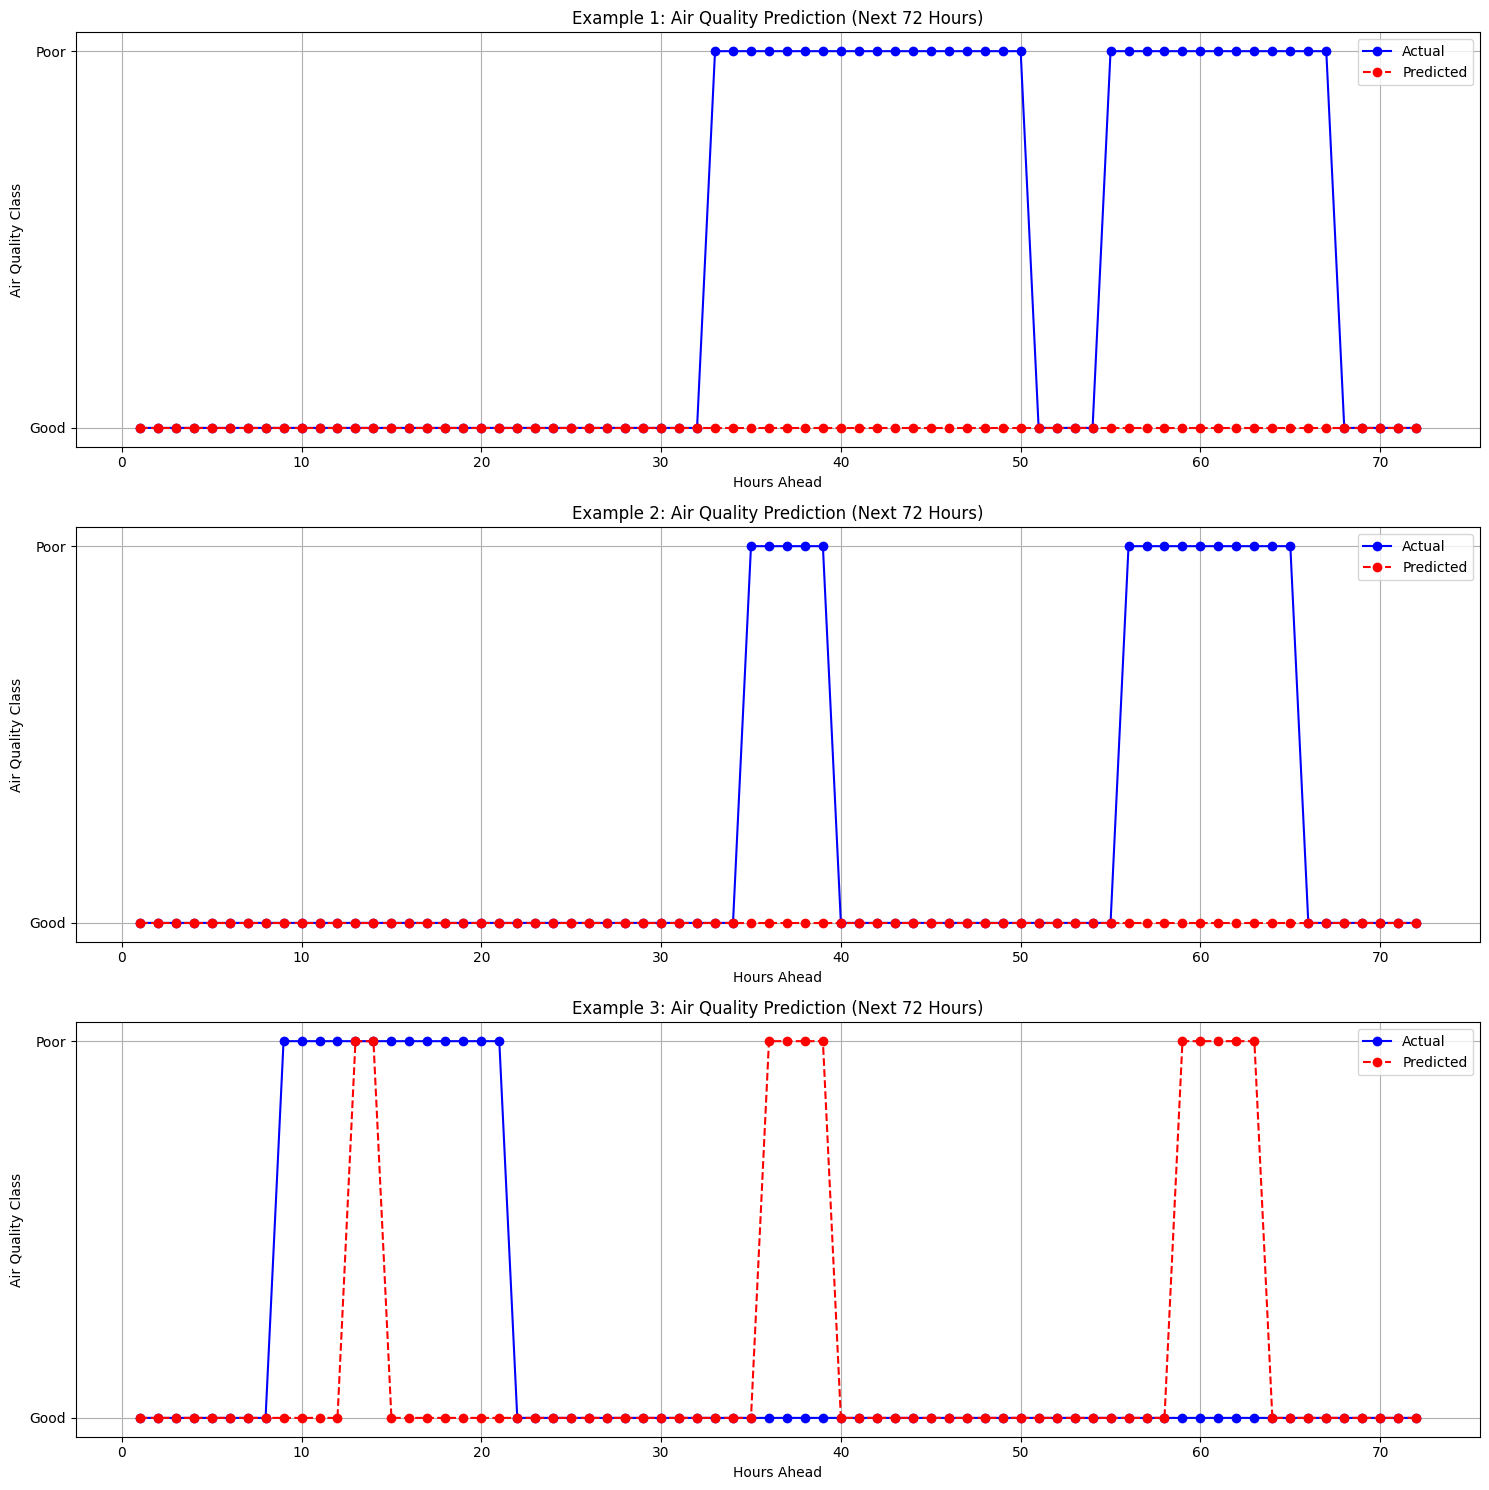

In [21]:
print("\nGenerating example predictions...")
X_test_plot = []
y_test_plot = []
for X_batch, y_batch in val_loader:
    X_test_plot.append(X_batch)
    y_test_plot.append(y_batch)
X_test_plot = torch.cat(X_test_plot, dim=0).numpy()
y_test_plot = torch.cat(y_test_plot, dim=0).numpy()

plot_example_predictions(model, X_test_plot, y_test_plot, num_examples=3)